#     Mean Shift Algorithm                                  Nicole Stafford


In [31]:
# imports needed functions/ methods
import math as m
from math import *

import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

import statistics as stats

import cv2

from skimage import io, color

from skimage import exposure

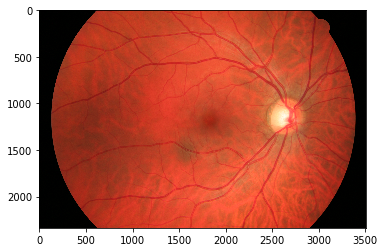

In [32]:
# downloads image to process these are image locations on my computer
#image = io.imread('Pictures\color_test.png')
image = io.imread('Pictures\eye.jpg')
#image = io.imread('Pictures\Halloween.jpg')
#plt.imshow(image1)
#image = image1[1000:2000,1000:2000]

plt.imshow(image)

In [33]:
## gets dimensions of picture to appropriatly prealocate arrays
height = image.shape[0]
width = image.shape[1]
# gets number of individal pixels in the image
N = int(image.size/3)
# number of dimensions of the data (for an image is 3)
d = 3
# radius of defining clusters (specifics how close clusters need to be grouped together)
radius = 50

# creates one matrix that stores all relevant data about a pixel point
# the last column is the current cluster assigment
# the second to last column is the pixel number in the image
# the third to last column is the distance from the current pixel or centroid
# the first d columns are the data being segmented
# the next d columns are the current centroid for that data point
data_mat = np.zeros((N, 2*d+3))

# prepares data into formate that can use for matricies
datatest = image.flatten()
data = datatest.reshape(N,d)

In [34]:
# prealocates cluster groups for tracking in the while loops
cen_vect = np.empty((N,d))
curr_cluster_group = np.zeros((1,N))
prev_cluster_group = np.ones((1,N))

# populated data matrix with appropriate pixel numbers and data points
data_mat[:,-1] = curr_cluster_group
data_mat[:,-2] = range(0,N)
data_mat[:,0:d] = data


# transposes these to make column vectors to match each data point
curr_cluster_group = curr_cluster_group.transpose()
prev_cluster_group = prev_cluster_group.transpose()

curr_cluster = curr_cluster_group
prev_cluster = prev_cluster_group

# keeps track of how many clusters are created and what pixel is being evaluated
cluster_num = 1;
cur_pixel_num = 0;

The next block is the meat of the algorithm. I first started with an out loop that itterated over each pixel to check that it was catagorized into a cluster, but this was very long. I tried to shorten the time by after a cluster was created checking my cluster classification column to find the next zero point (which means the data point has not been assigned a cluster yet) and use that as my new centroid point. Also, I first wasn't sure how to put in new cluster assigments into my data matrix when the indexes were not right in a row. I was first sorting using arg.sort my data matrix a couple times while I put new updated values for different clusters. This also added a lot of computation time since I was sorting thorugh the image three times every itteration of the while loop. I was able to figure out how to replace indices in the matrix without having to sort through them which also greatly reduced the computation time.

In [35]:
# outter while loop checks that ever data point has been assigned a cluster (so does not contain a zero) if all values are 
# non zero then ever data point has been groupd and the segmentation 
while(np.isin(0, curr_cluster_group)):
    # updates current data point and cluster grouping for next itteration
    prev_cluster_group = curr_cluster_group
    curr_pixel = data[cur_pixel_num]
    cen_vect[: :] = curr_pixel
    prev_cluster = np.empty((1,N))
    
    # this while loop groups different pixels that are within the specified radius together and continues adding pixels into 
    # the group unitl the centorid of the radius does not change
    while (True):
        #checks if current pixel has been asigned to a cluster if so doesn't continue to compute
        if curr_cluster_group[cur_pixel_num]!=0:       
            break
        # if no more new points are being added then cluster is complete
        if (np.array_equal(curr_cluster, prev_cluster)):
            break
        # stores previous groupings to check if there has been any changes at the end
        prev_cluster = curr_cluster

        # calculates distance to everypoint from the current pixel
        # make an array for each cluster the size of the number of data points      
        diff = data - cen_vect
        trans = diff.transpose()
        square = np.square(trans)
        distance = square.transpose()      
        dis = np.sum(distance, axis=1)   
        distance = np.sqrt(dis)
        # adds new distance values to data storage matrix
        data_mat[:,-3] = distance
        
       
        # gives indexes that are withing the radius values and should be added to the cluster
        testindex = [i for i,v in enumerate(distance) if v < radius]
              
        # calculates new centroid value and addes them into the data storage matrix
        test_centroid = np.mean(data_mat[testindex, 0:d], axis = 0)
        data_mat[testindex, d:2*d ] = test_centroid
        # adds the cluster number for each data point into the storage matrix
        data_mat[testindex, -1 ] = cluster_num
       
        # set cluster groups 
        curr_cluster = data_mat[:,-1]
        
        # make an array for each cluster the size of the number of data points
        cen_vect[: :] = test_centroid
        
    # now assign all data points previous classified to that cluster with the final centroid 
    assigment = np.where(data_mat[:,-1]== cluster_num)
    if (assigment[0].size != 0):
        data_mat[assigment, d:2*d ] = test_centroid
        cluster_num = cluster_num + 1
    
    # assigning current cluster grouping into the data matrix
    curr_cluster_group = data_mat[:,-1]
    
    # moving to next pixel but first finds where the next unassigned one is to try and reduce computation time
    cur_pixel_num = np.where(curr_cluster_group == 0)[0]
    if (cur_pixel_num.size !=0):
        cur_pixel_num = cur_pixel_num[0]
        print('next pixel', cur_pixel_num)

next pixel 620
next pixel 621
next pixel 623
next pixel 784
next pixel 348869
next pixel 511040
next pixel 898949
next pixel 2760406
next pixel 3464523
next pixel 3678303
next pixel 3758921
next pixel 3906084


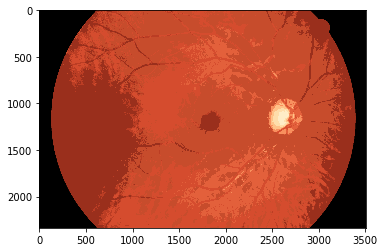

In [36]:
# now plot the new image by reshaping into the dimensions of the image
new_image = data_mat[:, d:d*2]
new_image = new_image.astype(int)
image_shape = np.reshape(new_image, (height, width, d))
plt.imshow(image_shape)

Example Segmentations

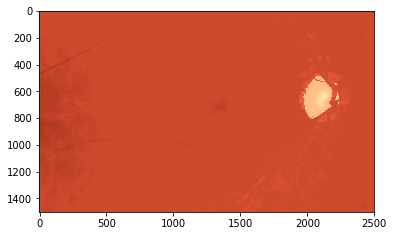

In [137]:
test_output2 = image_shape
plt.imshow(test_output2)
# this was with radius 50 on a part of an eye image zoomed in to the center

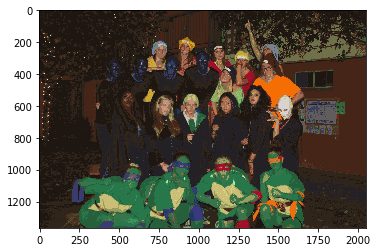

In [163]:
test_output = image_shape
plt.imshow(test_output)
# this was with radius 50 on a picture from my computer with lots of different colors

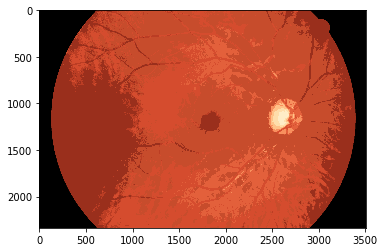

In [169]:
test_output3 = image_shape
plt.imshow(test_output3)
# this was with radius 50 on a full eye image

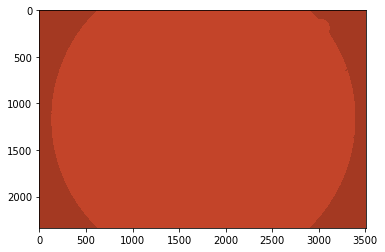

In [30]:
# example of bad segmenation when the radius is too large here I used a radius of 200 
test_output4 = image_shape
plt.imshow(test_output4)

Calculating DICE coefficient I would turn one of the well segmented images into a binary image I would proablby seperate and try to segment using the whitish circle in the center then take the difference from the pre processed binary images from the repository 

DICE is calculated by 2* probability that the pixel is classified correctly in by my segmentation and the ground truth from the repository divided by the probablity my segmentation clasified the pixel plus the proablity the ground truth clasiffied the pixel correctly

since it is binary I would assigned 1s as the pixels for the whitish circle and 0 to all the other background when I would subtract the binary of my segmentation and the ground truth the number of zeros would be the pixels that were both classified the same between the two images. Since I am subtracting the ground image from my segmentation the values that are 1 would be the pixels that the ground truth identified, but my segmentation did not and the values that were -1 would be the pixels my segmentation identified, but the ground truth did not. To get probabilities of everything it would be the number of 0s, 1s, -1s respectivlty divided by the number of total pixels